# Comparison of Girvan & Newman's, and Newman's fast algorithm for community detection in graphs

---


### Girvan & Newman's algorithm:

Originally described in 2003 [[1]](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC122977/) the algorithm of Girwvan and Newman (GN) is a divisive clustering approach based on the idea that all the shortest paths connecting two clusters run through the few edges connecting the communities. Therefore by removing the edges which are part of the most shorts paths, the graph could fall apart to form the desired disonnected components: the communities.

The algorithm is originally desribed as follows:

> 1. Calculate the betweenness for all edges in the network.
> 2. Remove the edge with the highest betweenness.
> 3. Recalculate betweennesses for all edges affected by the removal.
> 4. Repeat from step 2 until no edges remain.

After removing all the edges the result is a hierachical clustering, a dendogram. To obtain an optimal clustering usually the levels of the dendrogram are evaluated with a score, and the best one is selected. A popular score is the modularity which is orignally defined as follows:

> Let $e_{ij}$ be the fraction of edges in the network that conn􏰀ect vertices in group $i$ to those in group $j$, and let $a_i = \sum_j e_{ij}$ Then

> $Q = \sum_i e_{ii} - a_i^2 $

> is the fraction of edges that fall within communities, minus the expected value of the same quantity if edges fall at random without regard for the community structure.

The GN algorithm is relatively slow, and it scales with $ O(m^2 n) $ for general graphs, and $O(n^3)$ for the frequently analyzed sparse graphs. The bad scaling make this method practically unusable for graph larger than some thousand nodes.


### Newman's fast algorithm

Newman's fast algorithm (NF) [[2]](http://arxiv.org/pdf/cond-mat/0309508v1.pdf) is an agglomerative approach which tries to directly optimize the modularity score. Starting from each node as a distinct cluster it merges clusters in each step. The candidates are selected to maximize the gain in modularity in the step, therefore it is a greedy optimaztion algorithm. 


The most important feature of the NF algorithm is that it is much faster than GN, and scales better,  $ O((m+n) n) $ for general graphs, and $O(n^2)$ for sparse graphs. 


--- 

## Test the algorithms on  synthetic bechmark graphs

### The Girvan-Newman random graphs:

To test the efficiency of a community detection algorithm simulated graphs with ground truth communities can be used in a relatively straighforward way (compared to real world graphs, where the "real" communities are not known). Girvan and Newman proposed such a synthetic benchmark network architecture.

> Each graph was constructed with 128 vertices divided into four communities of 32 vertices each. Edges were placed between vertex pairs independently at random, with probability Pin for vertices belonging to the same community and Pout for vertices in different communities, with Pout < Pin. The probabilities were chosen so as to keep the average degree z of a vertex equal to 16. This produces graphs that have known community structure, but which are essentially random in other respects. 


To test the result of a community detection algorithm they introduced the score called "fraction of vertices classified correclty" (FVCC) :

>We find the largest set of vertices that are grouped together by the algorithm in each of the four known communities. If the algorithm puts two or more of these sets in the same group, then all vertices in those sets are considered incorrectly classi- fied. Otherwise, they are considered correctly classified. All other vertices not in the largest sets are considered incorrectly classified.

( Please note that the decription of the FVCC score can not be found in the arxiv version of the article, only in the [published ones](http://journals.aps.org/pre/abstract/10.1103/PhysRevE.69.066133) ).

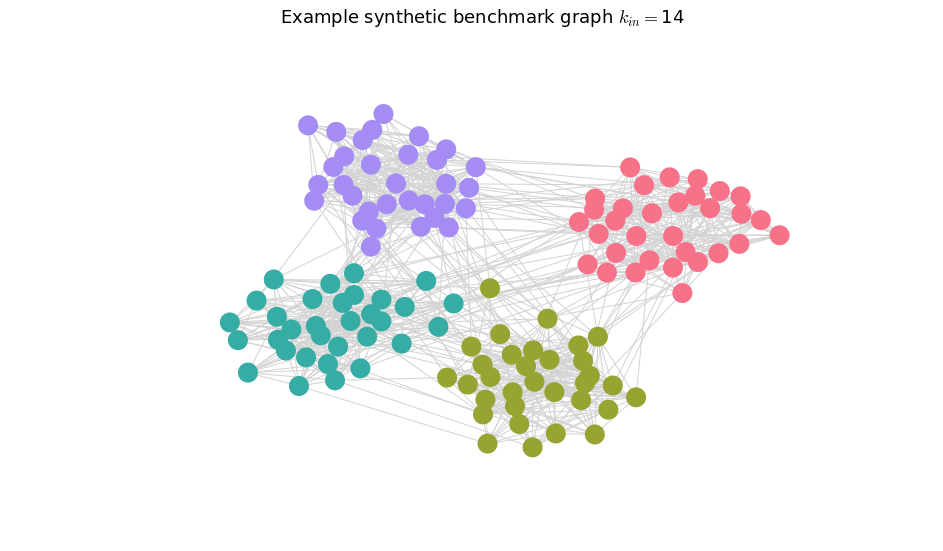

In [2]:
import sys
sys.path.append('my_modules/')
%matplotlib inline
from girwan_newman_benchmark import plot_example_graph

#plot an example GN benchmark graph
plot_example_graph(k_in=14)

---

### Efficiency of the algorithms on synthetic test graphs


By changing the number of edges connecting communities in the graphs, we can create easier, and harder excercises for the community detection. To test the effiecency of algorithms depending of the difficulty of the test graph, they were applied to graphs ranging from simple ones with 0 edges connecting original components, to impossible ones with 12 edges between components. The results are plotted below, each point in an average over 100 random graphs.

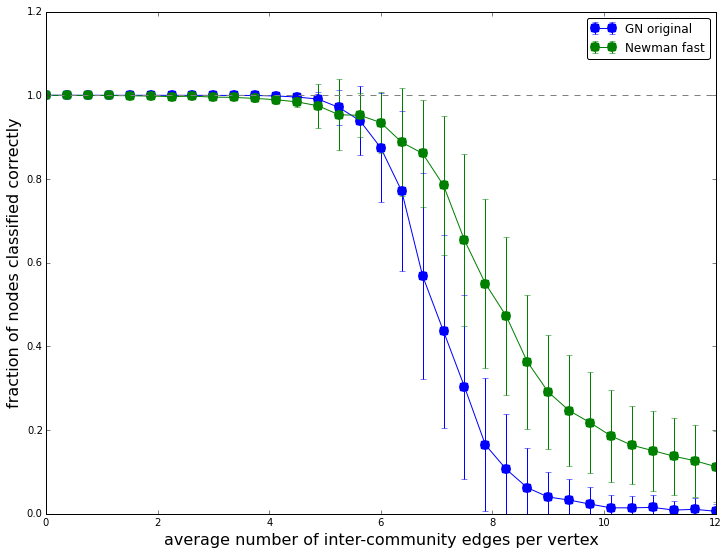

In [3]:
import igraph 
from igraph_method_wrappers import scan_k_in_vals
import numpy as np
import matplotlib.pyplot as plt

N=33 # number of k_in values
M=10 # repetition number

#the methods
GN=igraph.Graph.community_edge_betweenness
N_fast=igraph.Graph.community_fastgreedy

#run test
GN_res,krange=scan_k_in_vals(GN,N=N,M=M)
N_fast_res,krange=scan_k_in_vals(N_fast,N=N,M=M)

#plot the result
fig,ax=plt.subplots()
fig.set_size_inches(12,9)
ax.errorbar(16-krange,np.mean(GN_res,axis=1),np.std(GN_res,axis=1),
            marker='o',c='blue',ms=10,mec='none',label='GN original')
ax.errorbar(16-krange,np.mean(N_fast_res,axis=1),np.std(N_fast_res,axis=1),
            marker='o',c='green',ms=10,mec='none',label='Newman fast')
ax.axhline(1,linestyle='dashed',color='grey')
ax.set_ylim(0,1.2)
ax.legend(loc='best',fancybox=True)
ax.set_xlabel('average number of inter-community edges per vertex',fontsize=16)
dump=ax.set_ylabel('fraction of nodes classified correctly',fontsize=16)
fig.savefig('gn_nfast_comp_12_30.png')

#### Notes

The results look very similar to the ones described by Newman. The errorbars are much smaller there, so I assume he didn't use the std of the points but some other measure of incertainity, which he didn't describe in the article.


Note that Newman's algorithm "correctly classifies" higher fraction of the nodes, even when there is absolutely no structure to be found. The extra 10-20% of FVCC is only due to an artifact in FVCC score which prefers the output of NF algorithm over the GN. This factor should be considered when looking at the graph where FVCC is lower than 50-60%. Therefore the apparent superiority of Newman's fast algorithm with more than 6 inter-community edges per vertex should not be taken very seriously.




---

## Real world network

To compare the results of the two algorithms, I have applied them to a real world graph downloaded from [Stanford Large Network Dataset](https://snap.stanford.edu/data/). 

The GN algorithm is so slow that i had to select a relatively small network (~4k nodes, 80k edges ), and it was still running for almost a day. The analyzed [graph](https://snap.stanford.edu/data/egonets-Facebook.html) is a very small subset of the facebook friend network.

### Girvan-Newman agorithm

The method was running for around 20 hours, The best modularity achieved is 0.815. The method identified 182 unique clusters. 

### Newton's fast algorithm

The greedy modularity optimization finished in less than 2 seconds, more than 30000x faster than the GN algorithm! The best modularity achieved is  0.777 . The number of communitites found were much lower than before, only 14 !


### Comparing the results of the two algorithms

The GN algorithm found a result with better modularity score, but it took almost a day to run it, while Newton's fast algorithm is really fast, it has finished almost instantly. 

Visual inspection a 2D spring layout representations of the graph suggests, that the 14 communities found could be closer to "real" communities in the data, altough this evaluation is not exact.

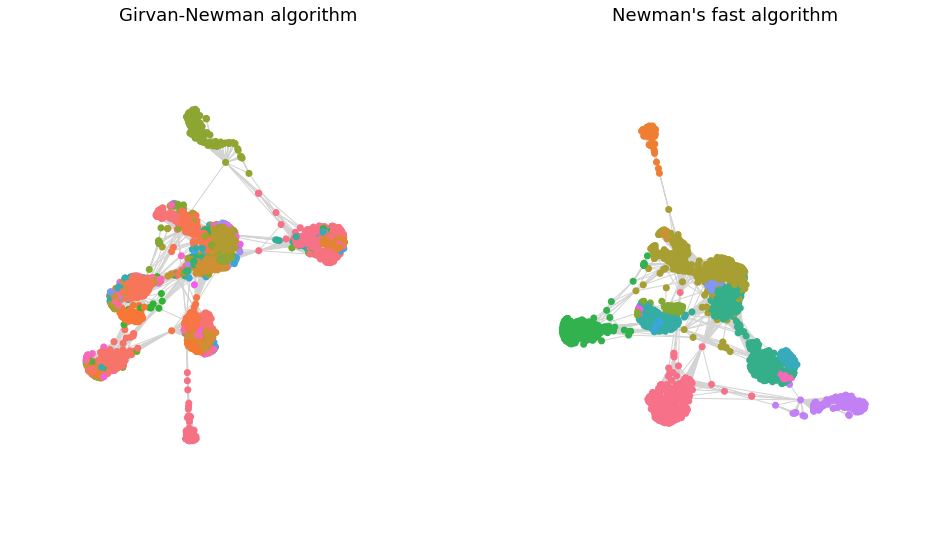

In [3]:
from igraph_method_wrappers import test_igraph_method_on_real_graph,plot_real_graph

NF_membership,NF_modularity,NF_time=test_igraph_method_on_real_graph('facebook_combined.txt',N_fast)
GN_membership,GN_modularity,GN_time=test_igraph_method_on_real_graph('facebook_combined.txt',GN)

fig=plt.figure(figsize=(16,9))
plot_real_graph('facebook_combined.txt',GN_membership,'Girvan-Newman algorithm',fig.add_subplot(1,2,1))
plot_real_graph('facebook_combined.txt',NF_membership,'Newman\'s fast algorithm',fig.add_subplot(1,2,2))

---

## Conlcusion

The most important difference between the two algorithms is the execution time. With a large enough graph it's useless to compare the results of the two methods, because the GN algorithm can not be run within acceptable time limit for a graph larger than some thousand nodes.


With smaller graphs, the synthetic benchmark tests suggest that the GN algorithm will find better results with not trivial, but not impossibly hard problems.


The test on the real graph gave some interesting results. The GN algorithm achieved a better modularity score than the greedy optimization of the modularity itself, suggesting that the results are better. On the other hand naive visual inspection of the results shows that the results of the NF algorithm might be more appropriate.

---

## Tools, sofware used

##### Python networkx library

I used this very user friendly graph api for creating the GN synthetic benchmark graphs. I have also implemented the GN algorithm using networkx, but it turned out to be so slow that I have started to look for a faster solution.

##### Igraph library

Igraph offers graph algorithms implemented in C with optimized data structures, and is therefore [orders of magnitude faster](https://graph-tool.skewed.de/performance) than the pure python NetworkX library. Igraph also offers built-in optimized implementations of both algorithms. 


##### Jupyter notebooks

Most of the work were done in jupyter notebooks, and all the notebook, and code can be found in a [github repository](https://github.com/riblidezso/graph_clust_alg_comparison)  created for the project.

---


## Bibliography

[1] Girvan, Michelle, and Mark EJ Newman. "Community structure in social and biological networks." Proceedings of the national academy of sciences 99.12 (2002): 7821-7826.


[2] Newman, Mark EJ. "Fast algorithm for detecting community structure in networks." Physical review E 69.6 (2004): 066133.


---

##### Code is hidden in this notebook click below to see it

In [4]:
#Toggle code

from IPython.display  import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

The notebook was created by Dezso Ribli